# Section 1: Data exploration and pre-processing

## Requirements and utilities


In [2]:
!pip install pandas scikit-learn nltk 

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.5/1.5 MB 9.6 MB/s  0:00:00m eta 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 803.5/803.5 kB 8.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2/2 [nltk]1/2 [nltk]


In [14]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.8 MB/s  0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993332 sha256=b68c029d347d192532e0ecba2d86feec580498607c44127d299dcb5ad4f1329f
  Stored in directory: /home/students/s356966/.cache/pip/wheels/eb/87/25/2dddf1c94e1786054e25022ec5530bfed52bad86d882999c48
Successfully built langdetect


In [3]:
!pip install seaborn matplotlib

In [ ]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from nltk.corpus import stopwords
import re
import nltk


In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

## 1. Data Exploration
*a. How many different attribute values do you observe in each feature? (e.g. how many
subreddits are there?) Is there any missing or duplicated data? (Referring to textual
features)*

*b. How does the empirical distribution of the number of characters in each comment look
like? How is the distribution of the number of comments per author? Is the supervised
dataset balanced between male and female? Are there only comments in English? Hint: use
the library langdetect.*

In [7]:

# loading the supervised data
df = pd.read_csv('../data/data_supervised.csv') 


print(f"Dataframe size: {df.shape}")
m = df.shape

# count differents subreddit topics and authors
n_distinc_authors = len(pd.unique(df['author']))
print(f"There are {n_distinc_authors} distinct authors")

# count distinct subreddit (topics)
n_distinct_subreddit = len(pd.unique(df['subreddit']))
print(f"There are {n_distinct_subreddit} distinct subreddit")

# count distinct body (comments)
n_distinct_body = len(pd.unique(df['body']))
print(f"There are {n_distinct_body} distinct body")

# checking missing values
print(df.isna().sum())

# checking empty stirng
print("Empty bodies: ",(df['body'].str.strip() == "").sum())

# checking duplicate values
n_duplicate = df.duplicated().sum()
print(f"Duplicate values {n_duplicate}")

# count rows with same author and same body
print(df['body'].duplicated().sum())


Dataframe size: (159086, 4)
There are 4508 distinct authors
There are 3081 distinct subreddit
There are 155892 distinct body
author         0
subreddit      0
created_utc    1
body           1
dtype: int64
Empty bodies:  0
Duplicate values 6
3194


count    159085.000000
mean        179.728642
std         327.190589
min           1.000000
25%          39.000000
50%          87.000000
75%         193.000000
max        9989.000000
Name: char_len, dtype: float64


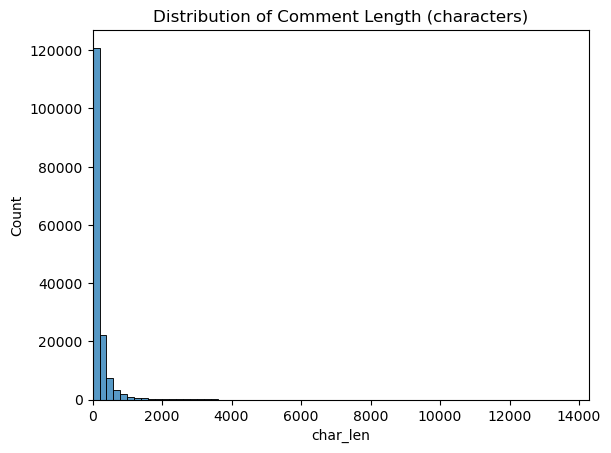

In [8]:
# collect the number of character for each comment
df['char_len'] = df['body'].str.len()

# describing the empirical distribution
print(df['char_len'].describe())

# plot the histogram
sns.histplot(df['char_len'], bins=50)
plt.title("Distribution of Comment Length (characters)")
plt.xlim(0, 14271) #CCC
plt.show()



count     4508.000000
mean        35.289707
std        200.733745
min          1.000000
25%          3.000000
50%         11.000000
75%         31.000000
max      12747.000000
Name: count, dtype: float64


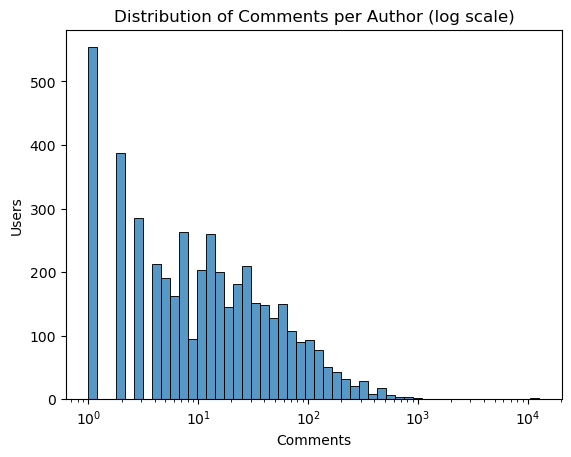

In [9]:
# comments per author
comments_per_author = df['author'].value_counts()
print(comments_per_author.describe())

plt.xlabel("Comments")
plt.ylabel("Users")

# plotting
sns.histplot(comments_per_author, bins=50, log_scale=True)
plt.title("Distribution of Comments per Author (log scale)")
plt.show()

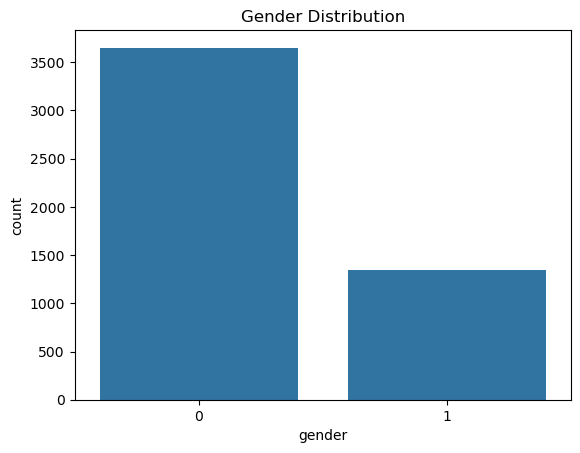

In [10]:
# reading the target_supervised
target = pd.read_csv('../data/target_supervised.csv')

target['gender'].value_counts()
target['gender'].value_counts(normalize=True)

sns.countplot(data=target, x='gender')
plt.title("Gender Distribution")
plt.show()

#CCC percentage

In [ ]:
!pip install fasttext

## 2. Data Cleaning and Text Standardization.

*a. Uniform text formats (e.g., case normalization, Hint: standardize the letters in lower case).If necessary, clean the comment text (e.g. URLs, subreddit refs, …).*

*b. Stop words are not contributing much to our ML tasks, such as "the", "a", since they carry very little information. Take care of these kinds of words.*

*c. Reduce words to their base or root form using Stemming/Lemmatization. This helps in
reducing inflected words to a common base form. (Hint: Consider using libraries like NLTK
or spaCy for tokenization).*


In [12]:
!pip install spacy

!python -m spacy download en_core_web_sm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.8/32.8 MB 63.7 MB/s  0:00:006m0:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 835.9/835.9 kB 13.4 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 17.0 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.9/3.9 MB 26.6 MB/s  0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.4/11.4 MB 37.4 MB/s  0:00:006m0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17/17 [spacy]m16/17 [spacy]open]y]
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 18.1 MB/s  0:00:00m0:00:0100:01
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')


In [15]:
# import needed python libraries

%matplotlib inline
from tqdm import tqdm
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

import html
import spacy
nlp = spacy.load("en_core_web_sm", disable=["parser","ner","textcat"])
from langdetect import detect

In [16]:
df_supervised   = pd.read_csv("../data/data_supervised.csv")
df_unsupervised = pd.read_csv("../data/data_unsupervised.csv")
df_target       = pd.read_csv("../data/target_supervised.csv")

print(df_supervised.shape, df_unsupervised.shape, df_target.shape)

(296042, 4) (1107946, 4) (5000, 2)


*Uniform text formats (e.g., case normalization, Hint: standardize the letters in lower case). If necessary, clean the comment text (e.g. URLs, subreddit refs, …).*



In [17]:
remove_pattern = r'https?://\S+|www\.\S+|r/\w+|u/\w+'

df_supervised['body_normalized'] = (
    df_supervised['body']
    .fillna('')                                     # To handling NaN
    .astype(str)                                    # Ensure string format
    .str.lower()                                    # Case normalization (Punto a.)
    .apply(html.unescape)                           # Decoding HTML (es. &amp; -> &)
    .str.replace(remove_pattern, ' ', regex=True)   # Removign URL, r/, u/
    .str.replace(r'\s+', ' ', regex=True)           # Removing double blanck spaces
    .str.strip()                                    # Strip
)

df_unsupervised['body_normalized'] = (
    df_unsupervised['body']
    .fillna('')
    .astype(str)
    .str.lower()
    .apply(html.unescape)
    .str.replace(remove_pattern, ' ', regex=True)
    .str.replace(r'\s+', ' ', regex=True)
    .str.strip()
)


In [18]:
print(df_supervised[["body", 'body_normalized']].head())

                                                body  \
0  I don't think we'd get nearly as much fanficti...   
1  Thanks. I made it up, that's how I got over my...   
2  Are you sure you aren't confusing Cyclops (the...   
3                             dont do this to me bro   
4        That's what we do when we can't find a mate   

                                     body_normalized  
0  i don't think we'd get nearly as much fanficti...  
1  thanks. i made it up, that's how i got over my...  
2  are you sure you aren't confusing cyclops (the...  
3                             dont do this to me bro  
4        that's what we do when we can't find a mate  


*b. Stop words are not contributing much to our ML tasks, such as "the", "a", since they carry very little information. Take care of these kinds of words.*

*c. Reduce words to their base or root form using Stemming/Lemmatization. This helps in reducing inflected words to a common base form. (Hint: Consider using libraries like NLTK or spaCy for tokenization).*

In [19]:
def process_text_full(text_series, batch_size=2000):
    clean_texts = []

    total_docs = len(text_series)

    # tqdm show the process bar
    for doc in tqdm(nlp.pipe(text_series, batch_size=batch_size), total=total_docs, desc="Processing"):

        tokens = []
        for token in doc:
            # 1. Filtering Stop Words e punctation (b)
            if not token.is_stop and not token.is_punct and not token.is_space:
                # 2. Take the lemma using spaCy (c)
                tokens.append(token.lemma_)

        clean_texts.append(" ".join(tokens))

    return clean_texts

print("Elaboration of SUPERVISED dataset (smaller)...")
df_supervised['body_clean'] = process_text_full(df_supervised['body_normalized'].astype(str))

df_supervised.to_csv("./clean_supervised.csv", index=False)

print("Elaboration of UNSUPERVISED  dataset (bigger)...")
df_unsupervised['body_clean'] = process_text_full(df_unsupervised['body_normalized'].astype(str))

df_unsupervised.to_csv("./clean_unsupervised.csv", index=False)


Elaboration of SUPERVISED dataset (smaller)...


Processing:   2%|▏         | 6000/296042 [00:24<19:34, 246.88it/s] 


KeyboardInterrupt: 

## 3 Text Vectorization.

*a. Only for the supervised task (data_supervised.csv): Group and join all comments of the
same author, creating a “new” dataset to be used for the supervised task (Section 2).*

*b: As ML algorithms struggle to handle directly the raw textual data. You are required to
convert the text into numerical representations (vectors) through Bag of Words (BoW).*

*c: Another way to assign a vector representation to a word is to associate the TF-IDF
representation (Term Frequency-Inverse Document Frequency) to each user/comment.
Can you observe and explain the differences between the numerical representations
generated by BoW and TF-IDF?*


*A Wrap up section at the bottom describing which files are created and where by this notebook is at the very end of the notebook. To change the input file instead view the very first cell of the notebook. Originally meant for only the supervised dataset as described by the requirements.*

For problems contact Matteo Sottocornola on Telegram.

### Part 1 of 1.3

*Only for the supervised task (data_supervised.csv): Group and join all comments of the
same author, creating a “new” dataset to be used for the supervised task (Section 2).*

In [27]:
# TODO capire se aggiungere aggregated subreddit/created_utc

# import as panda dataframe.
import pandas as pd
import numpy as np

df = pd.read_csv("../data/clean_supervised.csv") #In principio da usare solo su clean_supervised.
print(df.shape)

(296042, 6)


In [28]:
#Drop the two unneeded columns inside clean_supervised
#Rename the cleaned body to just body cause I prefer that way.
df = df.drop(columns=['body','body_normalized'])
df = df.rename(columns={'body_clean':'body'})

In [29]:
print(df.shape)

(296042, 4)


In [30]:
#Non sicuro se anche questi andrano tenuti/concatenati come body quindi drop per ora.
df_text_only = df.drop(columns=['created_utc','subreddit'])
print(df_text_only)

#nella parte 2 di Rocco ci sono testi che diventano vuoti (e giusto cosi erano interamente composti da stop words).
#Qui li sto semplicemente togliendo. Da notare che alcuni utenti vanno scartati
#perche non hanno piu nessun commento.
print(df_text_only.shape)
df_text_only = df_text_only.dropna(subset=['body']) #perdiamo un 6000 su 296,000 posts.
print(df_text_only.shape)


                  author                                               body
0            Shamus_Aran  think nearly fanfiction picture ship ban ban l...
1               Riddance                             thanks get heart break
2          Secret_Wizard  sure confuse cyclop easy boss monster ogre tal...
3           Penultimatum                                            not bro
4              7-SE7EN-7                                          find mate
...                  ...                                                ...
296037            Tashre                             want play game anymore
296038  someguyfromtheuk  twist son stag discover reddit account ^^^i'm ...
296039       spurscanada  think lot people like end prefer short term po...
296040           SPAZZEH                        tea party have stroke right
296041      whslaxattack                       huge rof boost pretty e8 gun

[296042 rows x 2 columns]
(296042, 2)
(290725, 2)


In [31]:
#come richiesto per ogni autore dobbiamo avere una sola riga con tutti i body concatenati.
df_grouped = df_text_only.groupby('author')['body'].apply(" ".join).reset_index()
print(df_grouped)

              author                                               body
0             -Jared  neil diamond sweet caroline +1 chiropractor go...
1            -Peeter                                           read faq
2           -evasian  receive deathadder black edition yesterday try...
3            -rubiks  alunageorge good believe arctic monkey high an...
4     -true_neutral-  > urban ear metis ymmv different pair month di...
...              ...                                                ...
4989           zot13  hey think exactly happen 3rd party controller ...
4990           zottz  get stick traffic pre widen huey train go text...
4991         zukinzo  afraid good thing remake remaster release tire...
4992            zzrr  hear bakery go ah yeah wrong flower shop > cla...
4993         zzuil93  love like meteorite go quick come mean enjoy l...

[4994 rows x 2 columns]


In [ ]:
#Quick sanity check.
i=4 #select an index, and as such a user.
user = df.iloc[i,0]
print("user: ", user," posted this: ", df.iloc[i, 3])

print(df.groupby("author").size().loc[user] )
#df.groupby("author").count()['author'=df.iloc[0, 0]]

row = df_grouped[df_grouped["author"] == user] #user
#print(row.iloc[0,1]) 
#You should see in the last print somewhere within the text a copy of the previously printed body.

In [33]:
#Convertiamo ad un numpy  per ragioni di efficenza/memoria.
numpy_grouped = df_grouped[["author","body"]].to_numpy()

### Part 2 of 1.3
*B: As ML algorithms struggle to handle directly the raw textual data. You are required to
convert the text into numerical representations (vectors) through Bag of Words (BoW).*

*Bag of Words (BoW) is a technique widely used to transform textual data into machine-readable format, specifically numerical values, without considering grammar and word order.*

*We will be counting the occurence of every word in the vocabulary we use. Where the word was and it's actual structure is lost. Basically you are adding a new column for each word that is in our dataset and adding the number of times it was used for each row.*

*Note that executing 1.2 to remove stop words first is heavily recomended to reduce the number of words and hence attributes we get with BoW.*

In [34]:
#useful example of BoW
#https://www.datacamp.com/tutorial/python-bag-of-words-model?dc_referrer=https%3A%2F%2Fwww.google.com%2F

from collections import defaultdict
import string

#df_grouped = df_grouped[:400] #remove after 1.2 available, done to reduce complexity for now.


#Dobbiamo creare un vocabolario di tutte le parole usate nei svariati body.
# Function to preprocess and tokenize
def preprocess(text):
    # Convert to lowercase
    text = text.lower()
    # Remove punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenize: split the text into words
    tokens = text.split()
    return tokens


vocabulary = set()

for sentence in numpy_grouped[:, 1]:
    tokens = preprocess(sentence)
    vocabulary.update(tokens)

vocabulary = sorted(vocabulary)

print(len(vocabulary))


110157


In [35]:
#Create a dictionary so future lookups are O(1)
word2idx = {w:i for i,w in enumerate(vocabulary)}

def create_bow_vector(sentence):
    vector = [0] * len(word2idx)  # Initialize a vector of zeros
    for word in sentence:
        idx = word2idx.get(word)  # Find the index of the word in the vocabulary using dictionary.
        if idx is not None:
            vector[idx] += 1  # Increment the count at that index
    return vector

#initialize numpy_bow
numpy_bow = np.zeros((numpy_grouped.shape[0], len(vocabulary)), dtype=np.int32)

# Create BoW vector for each author, i.e. for each body in our numpy_grouped.
for i ,raw_text in enumerate(numpy_grouped[:,1]):
    tokens = preprocess(raw_text) #tokenize.
    temp = create_bow_vector(tokens)
    numpy_bow[i, :] = temp

#Lento perche troppe parole nel vocabulary.

In [ ]:
np.set_printoptions(threshold=np.inf)
# most but not all will be zeroes, that's normal.

In [ ]:
#Ci servira scrivere da qualche parte anche autori per ricordarci a chi corrisponde.
authors = numpy_grouped[:, 0]   # shape (n_auth,)

print(authors.shape)
print(numpy_bow.shape)

In [39]:
#np.savetxt("1.3-bow-authors2.csv", authors, fmt="%s", delimiter=",")
#np.savetxt("1.3-bow_matrix.csv", numpy_bow, fmt="%d", delimiter=",")

np.save("1.3-bow_matrix.npy", numpy_bow)
np.save("1.3-bow-authors.npy", authors)
#poi si legge cosi.
#numpy_bow = np.load("bow_matrix.npy")
#authors = np.load("authors.npy")

### Part 3 of 1.3 - TF-IDF

*Another way to assign a vector representation to a word is to associate the TF-IDF
representation (Term Frequency-Inverse Document Frequency) to each user/comment.
Can you observe and explain the differences between the numerical representations
generated by BoW and TF-IDF?*

*For TF-IDF it is necessary to create the vocabulary of all the distinct words and then for each word performing the following calculation which requires computing these two first...*

![Fig1.png](Fig1.png)


*In practice for every word A and each user we calculate two metrics, one is what percentage of overall users used word A (log of this number). And the other is what percentage of the words used by that specific user correspond to A. The index is then the multiple of these two.*

*It's meant to provide a measure of how important each word is to that text, but corrected to cancel out words that are just common in general and not common to this specific text.*

In [40]:
#We reuse the vocabulary computed for the previous section so execute that first.
print(len(vocabulary))

110157


In [42]:
from collections import Counter
import math

# Count in how many documents each word appears
df_counter = Counter()

# Create BoW vector for each author, i.e. for each body in our numpy_grouped.
for raw_text in numpy_grouped[:,1]:
    tokens = preprocess(raw_text) #tokenize.
    unique_words = set(tokens)
    df_counter.update(unique_words)

N = authors.shape[0]            # number of documents

idf = [math.log(N / df_counter.get(word, 1)) for word in vocabulary]

In [43]:
print(type(idf))
print(len(idf))
print(len(vocabulary))

<class 'list'>
110157
110157


In [44]:
#now to compute the second metric TF and directly the TF-IDF
#word2idx from earlier is re used.

def create_TF_IDF_vector(sentence, idf):
    vector = [0] * len(idf)  # If not present in user's comment then TF-IDF is 0.
    
    for word in sentence:
        idx = word2idx.get(word)  # Find the index of the word in the vocabulary
        if idx is not None:
            vector[idx] += 1  # Increment the count at that index
    
    
    for i in range(len(idf)):
        vector[i] = vector[i] / len(sentence)
        vector[i] = vector[i] * idf[i]
    
    return vector

In [45]:
# Preallocate the full TF-IDF matrix
TFIDF_vectors = np.zeros((numpy_grouped.shape[0], len(idf)), dtype=float)


#TFIDF_vectors = []

# Create TF-IDF vector for each sentence in the processed corpus
for i, raw_text in enumerate(numpy_grouped[:,1]):
    tokens = preprocess(raw_text) #tokenize.
    #TFIDF_vectors.append(create_TF_IDF_vector(tokens,idf))
    temp = create_TF_IDF_vector(tokens, idf)
    TFIDF_vectors[i, :] = temp


In [1]:
print("Single DF-IDF row")
np.set_printoptions(threshold=np.inf)
#print(TFIDF_vectors[17])

Single DF-IDF row


NameError: name 'np' is not defined

In [47]:
#Debug - checks
ind = 0
for el in TFIDF_vectors[1]:
    if el != 0.0:
        print(el, ind)
    ind = ind + 1

2.0860935244930174 36451
0.5038768480805278 79596


In [48]:
#Debug - checks
print(idf[36451]*0.5, idf[79596]*0.5)

2.0860935244930174 0.5038768480805278


In [49]:
ind = 0
for el in TFIDF_vectors[18]:
    if el != 0.0:
        print(el, ind)
        print("index: ", ind, " TF-IDF: ", el, " for word: ", vocabulary[ind])
    ind = ind + 1

0.08754774235056602 23248
index:  23248  TF-IDF:  0.08754774235056602  for word:  come
0.3852838084106849 23757
index:  23757  TF-IDF:  0.3852838084106849  for word:  conclusion
1.0644990588549648 38974
index:  38974  TF-IDF:  1.0644990588549648  for word:  fortake
0.22357009324860788 86539
index:  86539  TF-IDF:  0.22357009324860788  for word:  share
0.10534616871475125 96080
index:  96080  TF-IDF:  0.10534616871475125  for word:  thank
0.060819953782309456 97111
index:  97111  TF-IDF:  0.060819953782309456  for word:  time
0.45041719813795833 102917
index:  102917  TF-IDF:  0.45041719813795833  for word:  ve
0.1842132873624969 107319
index:  107319  TF-IDF:  0.1842132873624969  for word:  write


In [50]:
#np.savetxt("1.3-tf_idf-authors.csv", authors, fmt="%s", delimiter=",")
#np.savetxt("1.3-tf_idf_matrix.csv", TFIDF_vectors, fmt="%d", delimiter=",")

np.save("1.3-tf-idf-matrix.npy", TFIDF_vectors)
np.save("1.3-tf-idf-authors.npy", authors)
#poi si legge cosi.
#numpy_bow = np.load("bow_matrix.npy")
#authors = np.load("authors.npy")

## 4 Reduce the complexity of your dataset.
*Threshold-based: BoW and TF-IDF representations use the same large vocabulary, which
can result in a very high-dimensional feature space. This may lead to issues like the curse of
dimensionality or even out-of-memory errors when processing the data. Use the BoW
representation to identify thresholds to reduce the dimensionality of the feature space of
either the BoW itself or the TF-IDF representation.*

*Hint: Consider removing words that are either too common or too rare, as they often carry
less useful information. One approach is to filter out words whose frequencies fall below a
lower quantile (Ql) or above an upper quantile (Qu).*

*Dimensionality Reduction: Try applying PCA to reduce the dimensionality of your features.
Does it work? How many components would you keep and why? Do the components you
obtain with PCA have a physical interpretation?*
*Note: The number of features is very large and both TF-IDF and BoW matrix are sparse.
Suggestion: Do not scale your dataset with StandardScaler. Indeed, subtracting the mean
from each feature will render the sparse matrix a dense one, drastically increasing memory
usage. Try working with the sparse format using scipy.sparse and apply Truncated SVD,
which is designed for sparse data.*


### Threshold-based

In [ ]:
from scipy import sparse

In [25]:
bow_matrix = np.load('1.3-bow_matrix.npy') 
authors = np.load('1.3-bow-authors.npy', allow_pickle=True) 

# print utilities
print(f"Original dimension: {bow_matr.shape}")
print(f"Type matrix: {type(bow_matr)}")

# converting in sparse matrix
bow_sparse = sparse.csr_matrix(bow_matr)
print(f"Dimensione sparsa: {bow_sparse.shape}")
print(f"Memoria risparmiata: {1 - bow_sparse.data.nbytes / bow_matr.nbytes:.1%}")


# compute frequency of words (sum per column)
word_freq = np.array(bow_sparse.sum(axis=0)).flatten()

# some stats
print(f"Min freq: {word_freq.min()}")
print(f"Max freq: {word_freq.max()}")
print(f"Mean freq: {word_freq.mean():.2f}")
print(f"Median freq: {np.median(word_freq):.2f}")

# percentiles
percentiles = [0, 0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
print("\nPercentiles distribution:")
for p in percentiles:
    print(f"  {p*100:2.0f}%: {np.quantile(word_freq, p):.2f}")




Original dimension: (4994, 110157)
Type matrix: <class 'numpy.ndarray'>
Dimensione sparsa: (4994, 110157)
Memoria risparmiata: 99.7%
Min freq: 1
Max freq: 50091
Mean freq: 37.42
Median freq: 1.00

Percentiles distribution:
   0%: 1.00
   1%: 1.00
   5%: 1.00
  10%: 1.00
  25%: 1.00
  50%: 1.00
  75%: 5.00
  90%: 26.00
  95%: 78.00
  99%: 652.44
  100%: 50091.00


### Visualization

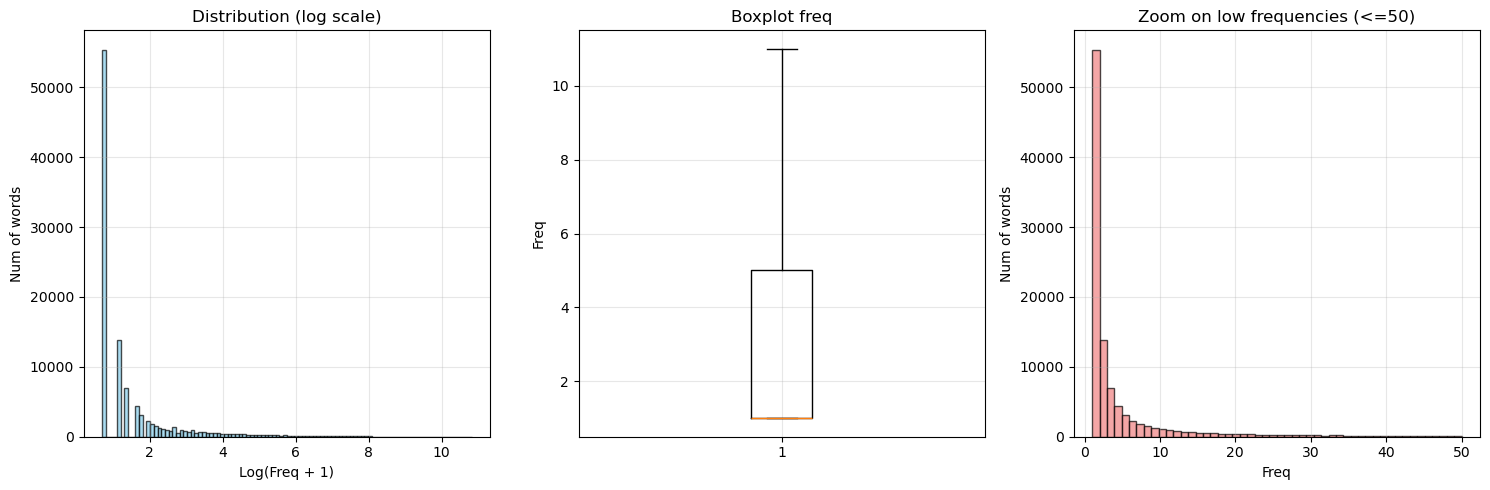

In [30]:
# visualization
plt.figure(figsize=(15, 5))

# Log distr
plt.subplot(1, 3, 1)
plt.hist(np.log1p(word_freq), bins=100, alpha=0.7, color='skyblue', edgecolor='black')
plt.xlabel('Log(Freq + 1)')
plt.ylabel('Num of words')
plt.title('Distribution (log scale)')
plt.grid(True, alpha=0.3)

# Boxplot
plt.subplot(1, 3, 2)
plt.boxplot(word_freq, showfliers=False)
plt.ylabel('Freq')
plt.title('Boxplot freq')
plt.grid(True, alpha=0.3)

# Zoom on low freq
plt.subplot(1, 3, 3)
low_freq = word_freq[word_freq <= 50]  # Solo frequenze <= 50 per vedere meglio
plt.hist(low_freq, bins=50, alpha=0.7, color='lightcoral', edgecolor='black')
plt.xlabel('Freq')
plt.ylabel('Num of words')
plt.title('Zoom on low frequencies (<=50)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()


### FIltering based on quantiles

In [40]:
Q_lower = 0.05
Q_upper = 0.95

lower_threshold = np.quantile(word_freq, Q_lower)
upper_threshold = np.quantile(word_freq, Q_upper)

print(f"Quantilies choosen: {Q_lower} - {Q_upper}")
print(f"Lower threshold (deleting words with freq <= {lower_threshold:.2f})")
print(f"Upper threshold (deleting words with freq >= {upper_threshold:.2f})")

# Apply the filtering
words_to_keep = (word_freq > lower_threshold) & (word_freq < upper_threshold)
bow_filtered = bow_sparse[:, words_to_keep]

# Stats of filtering
words_removed_lower = (word_freq <= lower_threshold).sum()
words_removed_upper = (word_freq >= upper_threshold).sum()
words_kept = words_to_keep.sum()

print(f"\nResults:")
print(f"Words before: {len(word_freq)}")
print(f"Removed rearest words: {words_removed_lower} ({words_removed_lower/len(word_freq)*100:.1f}%)")
print(f"Removed common words: {words_removed_upper} ({words_removed_upper/len(word_freq)*100:.1f}%)")
print(f"Words keeped: {words_kept} ({words_kept/len(word_freq)*100:.1f}%)")
print(f"Dim reducted: {(1 - words_kept/len(word_freq))*100:.1f}%")
print(f"Final BoW matrix: {bow_filtered.shape}")

Quantilies choosen: 0.05 - 0.95
Lower threshold (deleting words with freq <= 1.00)
Upper threshold (deleting words with freq >= 78.00)

Results:
Words before: 110157
Removed rearest words: 55399 (50.3%)
Removed common words: 5526 (5.0%)
Words keeped: 49232 (44.7%)
Dim reducted: 55.3%
Final BoW matrix: (4994, 49232)


### Showing results

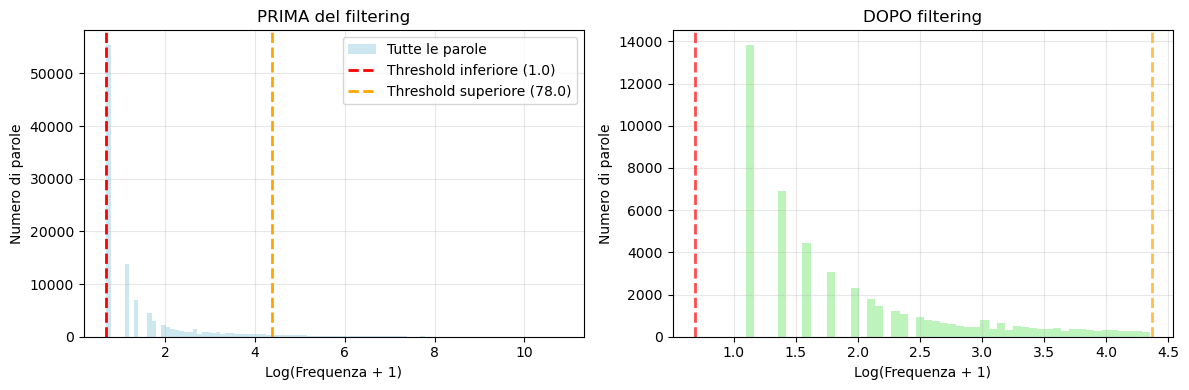

In [41]:
plt.figure(figsize=(12, 4))

# Before filtering
plt.subplot(1, 2, 1)
plt.hist(np.log1p(word_freq), bins=100, alpha=0.6, color='lightblue', label='Tutte le parole')
plt.axvline(np.log1p(lower_threshold), color='red', linestyle='--', linewidth=2, 
            label=f'Threshold inferiore ({lower_threshold:.1f})')
plt.axvline(np.log1p(upper_threshold), color='orange', linestyle='--', linewidth=2, 
            label=f'Threshold superiore ({upper_threshold:.1f})')
plt.xlabel('Log(Frequenza + 1)')
plt.ylabel('Numero di parole')
plt.title('PRIMA del filtering')
plt.legend()
plt.grid(True, alpha=0.3)

# After filtering
plt.subplot(1, 2, 2)
word_freq_filtered = word_freq[words_to_keep]
plt.hist(np.log1p(word_freq_filtered), bins=50, alpha=0.6, color='lightgreen')
plt.axvline(np.log1p(lower_threshold), color='red', linestyle='--', linewidth=2, alpha=0.7)
plt.axvline(np.log1p(upper_threshold), color='orange', linestyle='--', linewidth=2, alpha=0.7)
plt.xlabel('Log(Frequenza + 1)')
plt.ylabel('Numero di parole')
plt.title('DOPO filtering')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Saving results

In [43]:
# saving results
sparse.save_npz('1.4-bow_filtered_quantile.npz', bow_filtered)
np.save('1.4-words_kept_indices.npy', words_to_keep)

print(f"Files saved:")
print(f"1.4-bow_filtered_quantile.npz - Matrice BoW filtered")
print(f"1.4-words_kept_indices.npy - index words kept")

# TF-IDF
try:
    tfidf_matrix = np.load('1.3-tf-idf-matrix.npy')
    tfidf_sparse = sparse.csr_matrix(tfidf_matrix)
    tfidf_filtered = tfidf_sparse[:, words_to_keep]
    sparse.save_npz('1.4-tfidf_filtered_quantile.npz', tfidf_filtered)
    print(f"1.4-tfidf_filtered_quantile.npz - Matrix TF-IDF filtered")
    print(f"  Dimensione TF-IDF filtrata: {tfidf_filtered.shape}")
except FileNotFoundError:
    print(f"File not found")

print(f"Dataset: {bow_sparse.shape[1]} features")
print(f"Dataset filtered: {bow_filtered.shape[1]} features") 
print(f"Final reduction: {(1 - bow_filtered.shape[1]/bow_sparse.shape[1])*100:.1f}%")

Files saved:
1.4-bow_filtered_quantile.npz - Matrice BoW filtered
1.4-words_kept_indices.npy - index words kept
1.4-tfidf_filtered_quantile.npz - Matrix TF-IDF filtered
  Dimensione TF-IDF filtrata: (4994, 49232)
Dataset: 110157 features
Dataset filtered: 49232 features
Final reduction: 55.3%


## Appling the Truncated Single Value Decomposition

In [2]:
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfTransformer

In [6]:
# load data
bow_matrix = np.load('1.3-bow_matrix.npy') 
bow_sparse = sparse.csr_matrix(bow_matrix)
print(f"Original BoW: {bow_sparse.shape}")

tfidf_matrix = np.load('1.3-tf-idf-matrix.npy')
tfidf_sparse = sparse.csr_matrix(tfidf_matrix)
print(f"Matrice TF-IDF originale: {tfidf_sparse.shape}")
has_tfidf = True

Original BoW: (4994, 110157)
Matrice TF-IDF originale: (4994, 110157)


In [ ]:
# TEST OTTIMIZZATO --> not work
n_components_options = [100, 500, 1000, 2000]
explained_variances = []

for n_comp in n_components_options:
    svd = TruncatedSVD(n_components=n_comp, 
                       algorithm='randomized', 
                       n_iter=5,               
                       random_state=42)
    svd.fit(bow_sparse)
    explained_variances.append(svd.explained_variance_ratio_.sum())
    print(f"Componenti: {n_comp:4d} - Varianza spiegata: {svd.explained_variance_ratio_.sum():.3f}")

In [ ]:
# visualization of variance curve
plt.figure(figsize=(10, 6))
plt.plot(n_components_options, explained_variances, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of components')
plt.ylabel('Explained variance')
plt.title('Explained variance curve - Truncated SVD')
plt.grid(True, alpha=0.3)

In [ ]:
# Guide lines per 8'% - 90% of explained variance
plt.axhline(y=0.8, color='r', linestyle='--', alpha=0.7, label='80% of variance')
plt.axhline(y=0.9, color='g', linestyle='--', alpha=0.7, label='90% of variance')
plt.legend()
plt.show()

In [ ]:
# appling the truncated SVD

# choosing the number of components based of variance analysis
n_components_final = 1000  

print(f"Truncated SVD with {n_components_final} components...")

# For BoW
svd_bow = TruncatedSVD(n_components=n_components_final, random_state=42)
bow_svd = svd_bow.fit_transform(bow_sparse)
print(f"BoW after SVD: {bow_svd.shape}")

# For TF-IDF
svd_tfidf = TruncatedSVD(n_components=n_components_final, random_state=42)
tfidf_svd = svd_tfidf.fit_transform(tfidf_sparse)
print(f"TF-IDF after SVD: {tfidf_svd.shape}")

In [ ]:
# svd analysisi
print("First 10 components BoW - explained variance:")
for i, var in enumerate(svd_bow.explained_variance_ratio_[:10]):
    print(f"  Componente {i+1}: {var:.4f}")

# Total explained variance
total_variance_bow = svd_bow.explained_variance_ratio_.sum()
print(f"\ntotal explained variance BoW: {total_variance_bow:.3f}")

# Most important features
def print_top_features(svd_model, feature_names, n_features=10, n_components=3):
    """Stampa le feature più importanti per le prime componenti"""
    components = svd_model.components_
    for i in range(n_components):
        print(f"\nComponente {i+1} - Top features:")
        # Ottieni gli indici delle feature con peso assoluto più alto
        top_indices = np.argsort(np.abs(components[i]))[-n_features:][::-1]
        for idx in top_indices:
            # Nota: qui non abbiamo i nomi delle feature reali
            print(f"  Feature {idx}: peso {components[i][idx]:.4f}")

# Nota: Non abbiamo i nomi delle feature, quindi mostriamo solo gli indici
print("\nTop features per prime 3 componenti BoW:")
print("(Nota: senza nomi feature reali, mostro solo indici)")
for i in range(3):
    top_indices = np.argsort(np.abs(svd_bow.components_[i]))[-10:][::-1]
    print(f"Componente {i+1}: features {top_indices}")

In [ ]:
# Saving matrix
np.save('1.4-bow_svd_reduced.npy', bow_svd)
np.save('1.4-tfidf_svd_reduced.npy', tfidf_svd)

# Salva i modelli SVD
import joblib
joblib.dump(svd_bow, '1.4-svd_bow_model.pkl')
joblib.dump(svd_tfidf, '1.4-svd_tfidf_model.pkl')

print(f"Original: {bow_sparse.shape} -> reducted: {bow_svd.shape}")
print(f"Reduction: {(1 - bow_svd.shape[1]/bow_sparse.shape[1])*100:.1f}%")
print(f"Preserved variance: {total_variance_bow*100:.1f}%")

In [ ]:
# differences between truncated svd and threshold
try:
    bow_filtered = sparse.load_npz('1.4-bow_filtered_quantile.npz')
    print("CONFRONTO FINALE:")
    print(f"Threshold-based: {bow_filtered.shape} (mantiene parole reali)")
    print(f"Truncated SVD:    {bow_svd.shape} (componenti latenti)")
    print("\nVantaggi Threshold-based:")
    print("  • Features interpretabili (parole reali)")
    print("  • Mantiene semantica originale")
    print("\nVantaggi Truncated SVD:")
    print("  • Riduzione più aggressiva")
    print("  • Cattura correlazioni tra features")
    print("  • Meno sensibile al rumore")
    
except:
    print("Dati threshold-based non trovati per confronto")